In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%tensorflow_version 2.x

import tensorflow as tf
from tqdm import tqdm_notebook as tqdm

from tensorflow.keras.preprocessing.image import load_img ,img_to_array
import os
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.transform import resize

TensorFlow 2.x selected.


In [0]:
latent_dim=64
height=64
width=64
channels=3

In [0]:
!unzip '/content/drive/My Drive/data.zip'

In [0]:
list_file = os.listdir('data')
data_train_gan = np.array([resize(imread(os.path.join('data',file_name)), (H, W)) for file_name in list_file])

In [0]:
!rm -rf data

In [0]:
data_train_gan.shape

(21551, 64, 64, 3)

In [5]:
generator_input=tf.keras.Input(shape=(latent_dim,))


x=layers.Dense(128*32*32)(generator_input)
x=layers.LeakyReLU()(x)
x=layers.Reshape((32,32,128))(x) 

#32x32x128
x=layers.Conv2D(filters=256,kernel_size=5,padding='same')(x)
x=layers.LeakyReLU()(x)

#32x32x256
x=layers.Conv2DTranspose(filters=256,kernel_size=4,strides=2,padding='same')(x)
x=layers.LeakyReLU()(x)

#64x64x256
x=layers.Conv2D(filters=256,kernel_size=5,padding='same')(x)
x=layers.LeakyReLU()(x)
x=layers.Conv2D(filters=256,kernel_size=5,padding='same')(x)
x=layers.LeakyReLU()(x)

#64x64x256
x=layers.Conv2D(filters=channels,kernel_size=7,padding='same', activation='tanh')(x)

#64x64x3

generator=tf.keras.models.Model(generator_input,x)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense (Dense)                (None, 131072)            8519680   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 131072)            0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 64, 256)       104883

In [6]:
discriminator_input= layers.Input(shape=(height,width,channels))

#64x64x3
x=layers.Conv2D(filters=128,kernel_size=3)(discriminator_input)
x=layers.LeakyReLU(0.2)(x)
#62x62x128
x=layers.Conv2D(filters=128,kernel_size=4,strides=2)(x)
x=layers.LeakyReLU(0.2)(x)
#30x30x128
x=layers.Conv2D(filters=128,kernel_size=4,strides=2)(x)
x=layers.LeakyReLU(0.2)(x)
#14x14x128
x=layers.Conv2D(filters=128,kernel_size=4,strides=2)(x)
x=layers.LeakyReLU(0.2)(x)
#6x6x128

x=layers.Flatten()(x)

x=layers.Dropout(0.4)(x)

x=layers.Dense(1,activation='sigmoid')(x)

discriminator=tf.keras.models.Model(discriminator_input,x)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 62, 128)       3584      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0   

In [7]:
disc_opt=RMSprop(learning_rate=0.0008,clipvalue=1.0)
discriminator.compile(optimizer=disc_opt,loss='binary_crossentropy')

discriminator.trainable= False

gan_input= tf.keras.Input(shape=(latent_dim,))
gan_output= discriminator(generator(gan_input))
gan=tf.keras.Model(gan_input,gan_output)

gan_opt=RMSprop(learning_rate=0.0004,clipvalue=1.0)
gan.compile(optimizer=gan_opt,loss='binary_crossentropy')


gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
model (Model)                (None, 64, 64, 3)         13702915  
_________________________________________________________________
model_1 (Model)              (None, 1)                 795009    
Total params: 14,497,924
Trainable params: 13,702,915
Non-trainable params: 795,009
_________________________________________________________________


In [0]:
x_train = data_train_gan

In [0]:
batch_size = 128
save_dir='/content/drive/My Drive/Colab Notebooks/data_files/'

In [0]:
gan.load_weights(save_dir+'model.h5', by_name=False)

In [0]:
def save_imgs():
  noise=np.random.normal(size=(batch_size,latent_dim))
  fake=generator.predict(noise)

  N=5

  fig, axes = plt.subplots(N, N)
  fig.set_size_inches(2*N,2*N)
  count = 0
  for i in range(N):
    for j in range(N):
      axes[i, j].imshow(resize((fake[count]+1)/2, (64,64)))
      axes[i, j].axis('off')
      count += 1
  plt.savefig(save_dir+'gan_generated_image')
  plt.show()



In [0]:
def train(iterations):
  for step in tqdm(range(iterations)):
    noise=np.random.normal(size=(batch_size,latent_dim))
    fake=generator.predict(noise)

    real=x_train[np.random.randint(0,x_train.shape[0],size=batch_size)]

    combined=np.concatenate([fake,real])
    labels=np.concatenate([np.zeros((batch_size,1)),np.ones((batch_size,1))])

    labels+= 0.5* np.random.random(labels.shape)

    d_loss= discriminator.train_on_batch(combined,labels)

    noise=np.random.normal(size=(batch_size,latent_dim))
    targets=np.ones((batch_size,1))

    g_loss=gan.train_on_batch(noise,targets)

    if step % 50 == 0:
      print('discriminator loss:', d_loss)
      print('generator loss:', g_loss)
      save_imgs()
      
    if step % 100 == 0:
      gan.save_weights(save_dir+'model.h5')

In [0]:
train(2000)

Output hidden; open in https://colab.research.google.com to view.

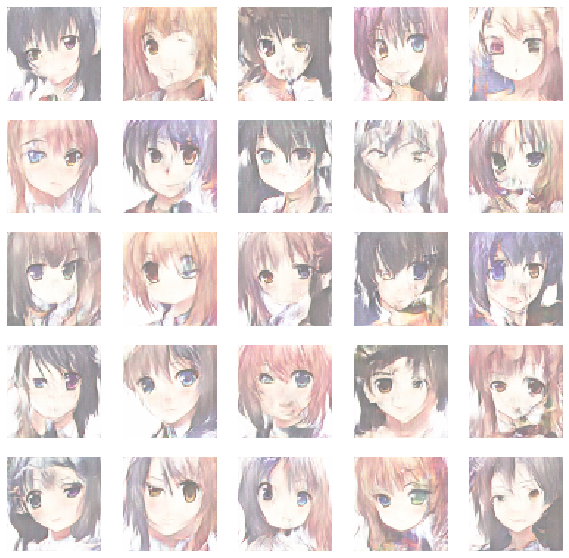

In [0]:
noise=np.random.normal(0,1,size=(batch_size,latent_dim))
fake=generator.predict(noise)

N=5

fig, axes = plt.subplots(N, N)
fig.set_size_inches(2*N,2*N)
count = 0
for i in range(N):
  for j in range(N):
    axes[i, j].imshow(resize((fake[count]+1)/2, (64,64)))
    axes[i, j].axis('off')
    count += 1
plt.savefig(save_dir+'gan_generated_image')
plt.show()

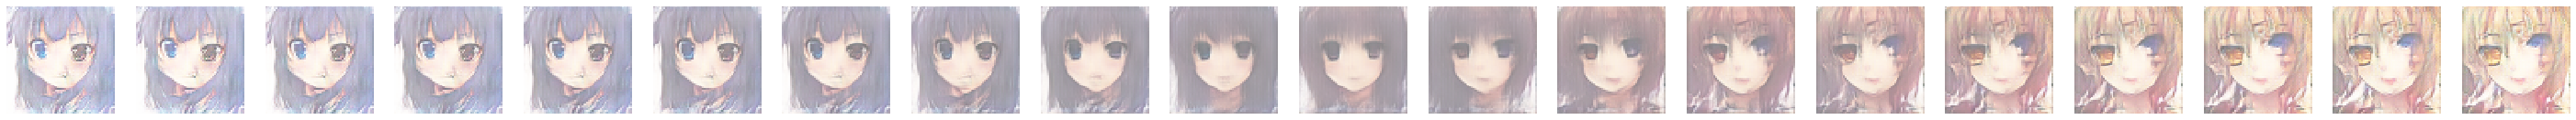

In [53]:
fig, axes = plt.subplots(1,20 )
fig.set_size_inches(50,50)
count=0

for i in range(-10,10):
  mean=i/10
  noise=np.random.normal(mean,0.1,size=(1,latent_dim))
  fake=generator.predict(noise)
  axes[count].imshow(resize((fake[0]+1)/2, (64,64)))
  axes[count].axis('off')
  count+=1
plt.savefig(save_dir+'1x20 latent space')
plt.show()


In [32]:

noise=np.random.normal(0,0.1,size=(64*20,latent_dim))

for j in range(64):
  for i in range(-10,10):
    noise[j*20+(i+10),j]+=i
fake=generator.predict(noise)
print(fake.shape)

fig, axes = plt.subplots(64,20)
fig.set_size_inches(50,50)


count=0
for j in range(64):
  for i in range(-10,10):
    axes[j,i+10].imshow(resize((fake[count]+1)/2, (64,64)))
    axes[j,i+10].axis('off')
    count+=1


(1280, 64, 64, 3)


In [50]:
fig.set_size_inches(25,80)
fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig(save_dir+'64x20 latent space')
fig

Output hidden; open in https://colab.research.google.com to view.